In [1]:
## Initial Imports
import numpy as np
from numpy import reshape
import matplotlib.pyplot as plt
import os
import cv2
import xml.etree.ElementTree as ET

In [2]:
## Loading Dataset
image_dataset = './Dataset/images'
annotations = './Dataset/annotations'

In [3]:
image_array = []
labels = []
def dim(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

for anot_file in sorted(os.listdir(annotations)):
    file_path = annotations + "/" + anot_file
    xml = ET.parse(file_path)
    root = xml.getroot()
    image = image_dataset + "/" + root[1].text

    # split pictures
    for bndbox in root.iter('bndbox'):
        [xmin, ymin, xmax, ymax] = dim(bndbox)
        img = cv2.imread(image)
        img_pr = img[ymin:ymax,xmin:xmax]
        img_pr  = cv2.resize(img_pr,(80, 80))
        image_array.append(np.array(img_pr))
        
    # get labels
    for obj in root.findall('object'):
        name = obj.find('name').text 
        labels.append(np.array(name)) 

In [4]:
x_images = np.array(image_array)
x_train = np.zeros(x_images.shape[:-1])
for i in range(x_images.shape[0]):
    x_train[i] = cv2.cvtColor(x_images[i], cv2.COLOR_BGR2GRAY)

In [5]:
## Transforming into 0 and 1
x_train = x_train/255.0

In [6]:
## Encoding labels
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
encoder = LabelEncoder().fit(labels)
encoded_labels = encoder.transform(labels)

In [7]:
## Checking shapes of dataset (images and labels)
print("Images shape:",x_train.shape)
print("Labels shape:", encoded_labels.shape)

Images shape: (4072, 80, 80)
Labels shape: (4072,)


In [8]:
## Splitting the dataset into 3 different levels. 
incorrect_mask_dataset = x_train[np.where(encoded_labels == 0)]
mask_dataset = x_train[np.where(encoded_labels == 1)]
without_mask_dataset = x_train[np.where(encoded_labels == 2)]

In [9]:
## Checking the shape of the 3 datasets after encoding
print("Wearing mask:", mask_dataset.shape)
print("Not wearing mask:", without_mask_dataset.shape)
print("Incorrect mask use:", incorrect_mask_dataset.shape)

Wearing mask: (3232, 80, 80)
Not wearing mask: (717, 80, 80)
Incorrect mask use: (123, 80, 80)


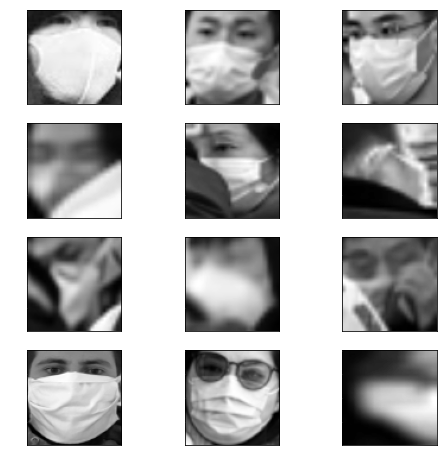

In [10]:
## Displaying images from people wearing mask
fig, axs = plt.subplots(4, 3, figsize=(8,8))
index = 0
for col in range(len(axs)):
  for cell in range(len(axs[col])):
    axs[col][cell].tick_params(axis='both', which='both', grid_alpha=0, colors="w")
    axs[col][cell].imshow(mask_dataset[index],cmap='gray')
    index += 1

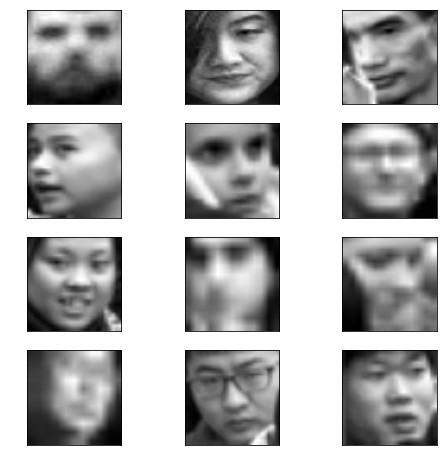

In [11]:
## Displaying images from not wearing mask
fig, axs = plt.subplots(4, 3, figsize=(8,8))
index = 0
for col in range(len(axs)):
  for cell in range(len(axs[col])):
    axs[col][cell].tick_params(axis='both', which='both', grid_alpha=0, colors="w")
    axs[col][cell].imshow(without_mask_dataset[index],cmap='gray')
    index += 1

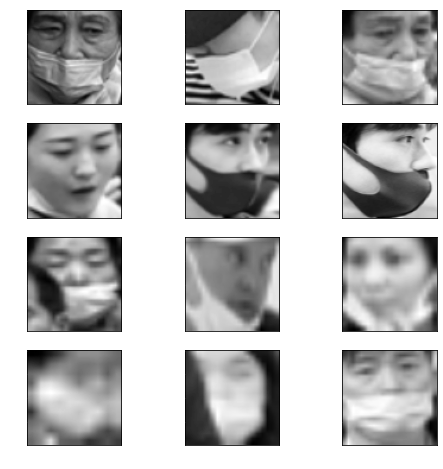

In [12]:
## Displaying images from people not wearing properly mask
fig, axs = plt.subplots(4, 3, figsize=(8,8))
index = 0
for col in range(len(axs)):
  for cell in range(len(axs[col])):
    axs[col][cell].tick_params(axis='both', which='both', grid_alpha=0, colors="w")
    axs[col][cell].imshow(incorrect_mask_dataset[index],cmap='gray')
    index += 1

In [13]:
## Shuffeling dataset and using batch size of 256
from tensorflow.data import Dataset
import tensorflow as tf
train_dataset_withMask = tf.data.Dataset.from_tensor_slices(mask_dataset).shuffle(len(mask_dataset)).batch(256)
train_dataset_withoutMask = tf.data.Dataset.from_tensor_slices(without_mask_dataset).shuffle(len(without_mask_dataset)).batch(256)


In [14]:
## Additional Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Reshape,BatchNormalization, LeakyReLU, Conv2DTranspose, Input,Conv2D, Dropout
from tensorflow import keras
from tensorflow.keras.losses import BinaryCrossentropy
from keras import backend as K

In [15]:
## Creating the generator model
generator_model = Sequential(name="generator_model")
generator_model.add(Input(100))
generator_model.add(Dense(20*20*256, use_bias=False))
generator_model.add(BatchNormalization())
generator_model.add(LeakyReLU())
generator_model.add(Reshape((20,20,256)))
generator_model.add(Conv2DTranspose(128, (5,5), use_bias=False, padding="same", strides=(1,1)))
generator_model.add(BatchNormalization())
generator_model.add(LeakyReLU())
generator_model.add(Conv2DTranspose(64, (5,5), use_bias=False, padding="same", strides=(2,2)))
generator_model.add(BatchNormalization())
generator_model.add(LeakyReLU())
generator_model.add(Conv2DTranspose(1, (5,5), use_bias=False, padding="same", strides=(2,2), activation="tanh"))
generator_model.add(Reshape((80,80,1)))

In [16]:
generator_model.summary()

Model: "generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102400)            10240000  
                                                                 
 batch_normalization (BatchN  (None, 102400)           409600    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 20, 20, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 128)  

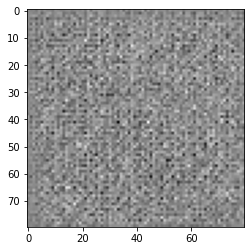

In [17]:
## Using tensorflow random.normal() to create noise on image and display
noise = tf.random.normal(shape=[1,100])
noise_image = generator_model(noise, training=False)
plt.imshow(noise_image[0, :, :, 0], cmap='gray')

In [18]:
## Creating the discrimator model
discriminator_model = Sequential()
discriminator_model.add(Conv2D(64, (5,5), strides=(2,2), input_shape=(80,80,1), padding="same"))
discriminator_model.add(LeakyReLU())
discriminator_model.add(Dropout(0.3))
discriminator_model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
discriminator_model.add(LeakyReLU())
discriminator_model.add(Dropout(0.3))
discriminator_model.add(Conv2DTranspose(64, (5,5), use_bias=False, strides=(2,2), padding="same"))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())
discriminator_model.add(Flatten())
discriminator_model.add(Dense(1))

In [19]:
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 40, 40, 64)        0         
                                                                 
 dropout (Dropout)           (None, 40, 40, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 128)       204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 20, 20, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 40, 40, 64)       2

In [20]:
## Creating loss function
def cross_entropy(y_pred, y_true):
    cross_entropy = BinaryCrossentropy(from_logits=True)
    return cross_entropy(y_pred, y_true)

In [21]:
## Optimizers
generator_optimizer = keras.optimizers.Adam()
discriminator_optimizer = keras.optimizers.Adam()

In [23]:
def train_step(images):
    noise = tf.random.normal([256, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   
        generated_images = generator_model(noise, training=True)
        
        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)
        
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [25]:
## Epoch training and time
import time
epochs = 10
for i in range(epochs):
    start = time.time()
    for batch in train_dataset_withMask:
        train_step(batch)
    end = time.time()
    duration_time = end - start
    print(f"Epoch:{i}, time:{duration_time}")

Epoch:0, time:247.98155879974365
Epoch:1, time:243.64562821388245
Epoch:2, time:238.6553931236267
Epoch:3, time:212.19888710975647
Epoch:4, time:127.61086082458496
Epoch:5, time:131.8531048297882
Epoch:6, time:128.42889308929443
Epoch:7, time:124.85099864006042
Epoch:8, time:128.6298382282257
Epoch:9, time:133.44323658943176


In [26]:
## Using random.normal()
vectors = []
for i in range(16):
    vector = tf.random.normal((1,100))
    vectors.append(vector)

In [27]:
## Generate an image from generator_model
generated_images = np.array(list(map(lambda vector: generator_model(vector, training=False), vectors)))

In [28]:
## Normalize the pixels
generated_images = (generated_images * 127.5) + 127.5

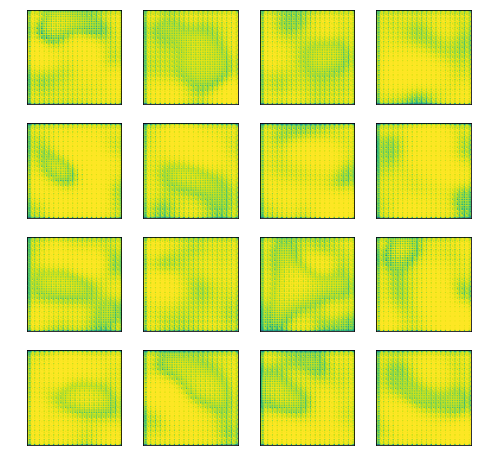

In [29]:
## Display plot image
fig, axs = plt.subplots(4, 4, figsize=(8,8))
current_index = 0
for col in range(len(axs)):
  for cell in range(len(axs[col])):
    axs[col][cell].tick_params(axis='both', which='both', grid_alpha=0, colors="w")
    axs[col][cell].imshow(generated_images[current_index].reshape(80,80))
    current_index += 1